# 평가 문항

|평가문항	|상세기준|
|:---|:---|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가? |	3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가? |	Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가? |	동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

In [54]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

데이터 정보
--------------------------------------------------
x_train : (8982,)
y_train : (8982,)
x_test : (2246,)
y_test : (2246,)
--------------------------------------------------
클래스의 수 : 46
--------------------------------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


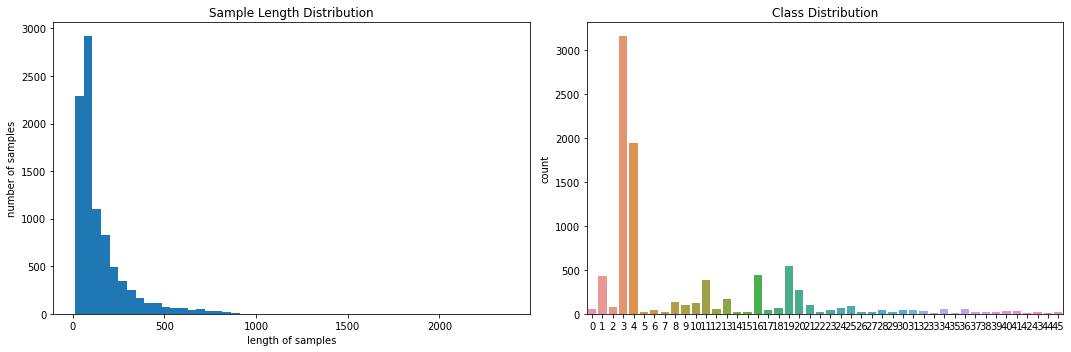

In [25]:
print('데이터 정보')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
print('-'*50)
print('x_train :',x_train.shape)
print('y_train :',y_train.shape)
print('x_test :',x_test.shape)
print('y_test :' ,y_test.shape)
print('-'*50)
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))
print('-'*50)
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0].hist([len(s) for s in x_train], bins=50)
axes[0].set_xlabel('length of samples')
axes[0].set_ylabel('number of samples')
axes[0].set_title('Sample Length Distribution')

# Plot the count of each class
sns.countplot(x=y_train, ax=axes[1])
axes[1].set_title('Class Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
def tf_idf(x_train, x_test):
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    # index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      index_to_word[index]=token
    # Decode
    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)

    x_train = decoded
    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)

    x_test = decoded_test
    # DTM
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    x_test_dtm = dtmvector.transform(x_test)
    # TF-IDF
    tfidf_transformer = TfidfTransformer()
    x_train = tfidf_transformer.fit_transform(x_train_dtm)
    x_test = tfidf_transformer.transform(x_test_dtm)
    return x_train, x_test

In [43]:
def process(num_words = 10000,    # 단어장 개수
            max_len_text = None,  # 데이터 길이 조정
            max_len_pad = 500,    # pad 길이
            vec_type= None,      # 벡터화 타입
            class_weight_bool = False  # class_weight 사용 여부
           ):
    # Data Load
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
                                                            num_words=num_words, 
                                                            test_split=0.2
                                                        )
    
    # 데이터 길이 제한
    if max_len_text:
        x_train = [x[:max_len_text] for x in x_train]
        x_test = [x[:max_len_text] for x in x_test]
        
    # tf_idf 방식으로 텍스트를 벡터화
    if vec_type == 'tfidf' :
        x_train, x_test = tf_idf(x_train, x_test)
    else:
        # Padding - TF-IDF 에서는 필요없음.
        x_train = pad_sequences(x_train, maxlen=max_len_pad)
        x_test = pad_sequences(x_test, maxlen=max_len_pad)
    

    
    # Class_weight
    if class_weight_bool:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        rf = RandomForestClassifier(n_estimators=5, random_state=0, class_weight=class_weight_dict)
    else:
        rf = RandomForestClassifier(n_estimators=5, random_state=0)
        
    # Models
    models = {
        'MultinomialNB' : MultinomialNB(),
        'ComplementNB' : ComplementNB(),
        'DecisionTreeClassifier' : DecisionTreeClassifier(max_depth=10, random_state=0),
        'RandomForestClassifier' : rf,
        'VotingClassifier':VotingClassifier(estimators=[ 
            ('mnb', MultinomialNB()),
            ('cnb', ComplementNB()),
            ('dt', DecisionTreeClassifier(max_depth=10, random_state=0)),
            ('rf', rf)
        ], voting='soft'),
#         'LogisticRegression' : LogisticRegression(C=10000, penalty='l2', max_iter=3000, random_state=0), # 10분 이상
#         'LinearSVC' : LinearSVC(C=1000, penalty='l1', dual=False, max_iter=3000, random_state=0), # 10분 이상
#         'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=0), # 15분 이상
        }
    
    accuracys = list()
    for idx, (name, model) in enumerate(models.items()):
        print(f"{idx}.모델 : {name}") 
        model.fit(x_train, y_train)
        predicted = model.predict(x_test) #테스트 데이터에 대한 예측
        print(f"\t정확도: {accuracy_score(y_test, predicted)}") 
        accuracys.append(accuracy_score(y_test, predicted))
        print(classification_report(y_test, predicted, zero_division=0))
        print('-'*50)
    print(f'평균 Acc : {sum(accuracys)/len(accuracys)}')


In [46]:
process()

0.모델 : MultinomialNB
	정확도: 0.2591273374888691
              precision    recall  f1-score   support

           0       0.06      0.08      0.07        12
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00        20
           3       0.53      0.67      0.59       813
           4       0.00      0.00      0.00       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.12      0.33      0.18         3
           8       1.00      0.05      0.10        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.08      0.11      0.09        83
          12       0.00      0.00      0.00        13
          13       0.01      0.03      0.02        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.14      0.03  

## Baseline 

In [39]:
process()

0.모델 : MultinomialNB
	정확도: 0.2591273374888691
1.모델 : ComplementNB
	정확도: 0.3597506678539626
2.모델 : DecisionTreeClassifier
	정확도: 0.40605520926090827
3.모델 : RandomForestClassifier
	정확도: 0.43455031166518254
4.모델 : VotingClassifier
	정확도: 0.3695458593054319
평균 Acc : 0.3658058771148709


# 텍스트 길이 500 적용 vs 미적용

- 속도 차이 : 기존 속도 빠른 모델로는 차이 없음
- 성능 차이 : 
    - 미적용 : 0.6871 
    - 적용 : `0.6878` ✅

## TF-IDF 적용 vs 미적용 

- 결과 
    - 미적용 : 0.3658
    - 적용 : `0.6871` ✅

## Class_weights 적용 vs 미적용

- DecisionTree 모델도 적용이 가능하지만, 적용하면 성능이 0.07로 떨어짐. 그래서 제외함
- RF 만 적용 ( 다른 모델은 시간이 오래 걸려서 Pass )

- 결과
    - 미적용 : 0.6871
    - 적용 : `0.6955` ✅

# 평가항목 (1)

- 평가문항 : 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
- 상세사항 : 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다

- 3가지 단어 개수 : 15000, 10000, 5000, None
- 8가지 머신러닝 기법 : 머신러닝 모델 8가지    

### 평가항목 (1) 결과표

- Acc

| 단어장 개수 | MultinomialNB | ComplementNB | DecisionTree | RandomForest | Voting | LogisticRegression | LinearSVC | GradientBoosting | 평균 Acc |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|None|0.6006|0.7666|0.6121|0.6821|0.6878|`0.8147`1️⃣|0.7916|0.7635|0.7149 |
|15000|0.6357|0.7711|0.6068|0.7012|0.7052|0.8130|0.7885|0.7644|0.7232 |
|10000|0.6567|0.7707|0.6179|0.7110|0.7172|0.8107|0.7876|0.7711|0.7304 |
|5000|0.6723|0.7711|0.6179|0.7128|0.7395|0.8049|0.7769|0.7649|`0.7325`✅ |

- 단어장이 늘어날수록⬆ 성능이 떨어지는 것⬇을 확인할 수 있다
- 가장 좋은 모델 & 단어장 개수 : `LogisticRegression ( None )`
- 최적의 솔루션 : process(num_words= 10000, vec_type= 'tfidf',class_weight_bool= True, max_len_text=500)

In [52]:
process(num_words= None, vec_type= 'tfidf',class_weight_bool= True, max_len_text=500)

0.모델 : MultinomialNB
	정확도: 0.6006233303650935
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.76      0.19  

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	정확도: 0.7916295636687445
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.74      0.71      0.72       105
           2       0.71      0.85      0.77        20
           3       0.91      0.92      0.92       813
           4       0.82      0.85      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      1.00      0.97        14
           7       1.00      0.33      0.50         3
           8       0.63      0.71      0.67        38
           9       0.84      0.84      0.84        25
          10       0.93      0.83      0.88        30
          11       0.64      0.73      0.69        83
          12       0.27      0.31      0.29        13
          13       0.55      0.49      0.51        37
          14       0.67      1.00      0.80         2
          15       0.86      0.67      0.75         9
          16       0.65      0.75      0.69        99
  

In [53]:
process(num_words= 15000, vec_type= 'tfidf',class_weight_bool= True, max_len_text=500)

0.모델 : MultinomialNB
	정확도: 0.6357969723953696
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.76      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.48      0.96      0.64       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.41      0.52        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.76      0.45  

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	정확도: 0.788512911843277
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.75      0.75       105
           2       0.72      0.65      0.68        20
           3       0.91      0.91      0.91       813
           4       0.81      0.85      0.83       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.88      0.84      0.86        25
          10       0.92      0.80      0.86        30
          11       0.67      0.73      0.70        83
          12       0.42      0.38      0.40        13
          13       0.50      0.57      0.53        37
          14       0.33      0.50      0.40         2
          15       0.67      0.44      0.53         9
          16       0.63      0.72      0.67        99
   

In [50]:
process(num_words= 10000, vec_type= 'tfidf',class_weight_bool= True, max_len_text=500)

0.모델 : MultinomialNB
	정확도: 0.6567230632235085
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.61      0.68      0.64       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.64      0.65        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56  

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	정확도: 0.7876224398931434
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.75      0.75      0.75       105
           2       0.67      0.70      0.68        20
           3       0.91      0.92      0.92       813
           4       0.81      0.84      0.83       474
           5       0.00      0.00      0.00         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.63      0.68      0.66        38
           9       0.76      0.88      0.81        25
          10       0.84      0.70      0.76        30
          11       0.66      0.75      0.70        83
          12       0.43      0.46      0.44        13
          13       0.60      0.57      0.58        37
          14       1.00      0.50      0.67         2
          15       0.71      0.56      0.63         9
          16       0.66      0.74      0.70        99
  

In [51]:
process(num_words= 5000, vec_type= 'tfidf',class_weight_bool= True, max_len_text=500)

0.모델 : MultinomialNB
	정확도: 0.672306322350846
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.51      0.79      0.62       105
           2       0.00      0.00      0.00        20
           3       0.85      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66   

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	정확도: 0.7769367764915405
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.72      0.71      0.72       105
           2       0.79      0.75      0.77        20
           3       0.89      0.90      0.90       813
           4       0.80      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       1.00      0.33      0.50         3
           8       0.67      0.68      0.68        38
           9       0.77      0.80      0.78        25
          10       0.88      0.77      0.82        30
          11       0.67      0.73      0.70        83
          12       0.50      0.38      0.43        13
          13       0.53      0.62      0.57        37
          14       0.67      1.00      0.80         2
          15       0.67      0.44      0.53         9
          16       0.65      0.71      0.68        99
  

# 평가항목 (2)

- 평가문항 : 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
- 상세사항 : Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

- `F1 단어장 개수별`

| 단어장 개수 | MultinomialNB | ComplementNB | DecisionTree | RandomForest | Voting | LogisticRegression | LinearSVC | GradientBoosting | 평균 f1 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|None|0.07|0.47|0.14|0.44|0.25|0.67|0.64|0.56|0.405 |
|15000|0.09|0.47|0.14|0.46|0.29|0.67|0.64|0.59|0.4187 |
|10000|0.10|0.48|0.18|0.48|0.33|0.66|0.62|0.59| `0.43` ✅|
|5000|0.11|0.48|0.16|0.47|0.35|0.65|0.61|0.57|0.4249 |

1. 나이브 베이즈류 모델은 단어장 개수(vocabulary size)가 작아질수록 F1 성능이 향상.
2. Voting 모델도 단어장 개수가 작아질수록 F1 성능이 향상되지만, 보팅 모델이 나이브 베이즈류 모델이 많은 것으로 추정됨
3. 그 외 모델은 단어장 10,000개에서 F1 성능이 가장 좋음

- `F1 클래스별`

| Class | MultinomialNB | ComplementNB | DecisionTree | RandomForest | Voting | LogisticRegression | LinearSVC | GradientBoosting | 평균 F1 | 비율(%) |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0 | 0.00 | 0.76 | 0.00 | 0.64 | 0.67 | 0.76 | 0.78 | 0.75 | 0.545 | 0.61 % |
| 1 | 0.64 | 0.74 | 0.53 | 0.62 | 0.67 | 0.76 | 0.75 | 0.72 | 0.6787 | `4.81 %` |
| 2 | 0.00 | 0.62 | 0.48 | 0.59 | 0.62 | 0.70 | 0.68 | 0.70 | 0.5487 | 0.82 % |
| 3 | 0.85 | 0.90 | 0.87 | 0.86 | 0.88 | 0.92 | 0.92 | 0.89 | 0.8862 | `35.17 %` |
| 4 | 0.67 | 0.83 | 0.55 | 0.73 | 0.73 | 0.84 | 0.83 | 0.80 | 0.7474 | `21.7 %` |
| 5 | 0.00 | 0.00 | 0.00 | 0.33 | 0.00 | 0.00 | 0.00 | 0.29 | 0.0775 | 0.19 % |
| 6 ❓ | 0.00 | 0.93 | 0.78 | 0.69 | 0.67 | 0.93 | 0.83 | 0.87 | 0.7125 | 0.53 % |
| 7 | 0.00 | 0.80 | 0.00 | 0.50 | 0.50 | 0.50 | 0.50 | 0.50 | 0.4125 | 0.18 % |
| 8 | 0.00 | 0.21 | 0.00 | 0.58 | 0.35 | 0.69 | 0.66 | 0.66 | 0.3937 | `1.55 %` |
| 9 | 0.15 | 0.87 | 0.88 | 0.68 | 0.76 | 0.85 | 0.81 | 0.80 | 0.725 | `1.12 %` |
| 10 | 0.00 | 0.87 | 0.81 | 0.81 | 0.81 | 0.90 | 0.76 | 0.87 | 0.7287 | `1.38 %` |
| 11 | 0.65 | 0.63 | 0.57 | 0.58 | 0.64 | 0.69 | 0.70 | 0.62 | 0.635 | `4.34 %` |
| 12 | 0.00 | 0.00 | 0.00 | 0.22 | 0.13 | 0.48 | 0.44 | 0.48 | 0.2187 | 0.55 % |
| 13 | 0.05 | 0.59 | 0.00 | 0.45 | 0.36 | 0.62 | 0.58 | 0.54 | 0.3987 | `1.91 %`|
| 14 | 0.00 | 0.00 | 0.00 | 0.80 | 0.00 | 0.80 | 0.67 | 0.22 | 0.3112 | 0.29 % |
| 15 | 0.00 | 0.18 | 0.00 | 0.20 | 0.00 | 0.57 | 0.63 | 0.38 | 0.245 | 0.22 % |
| 16 | 0.61 | 0.72 | 0.68 | 0.58 | 0.71 | 0.74 | 0.70 | 0.73 | 0.6837 | `4.94 %` |
| 17 | 0.00 | 0.00 | 0.00 | 0.22 | 0.00 | 0.73 | 0.59 | 0.72 | 0.2825 | 0.43 % |
| 18 | 0.00 | 0.57 | 0.00 | 0.42 | 0.09 | 0.74 | 0.72 | 0.60 | 0.3925 | 0.73 % |
| 19 | 0.68 | 0.65 | 0.50 | 0.63 | 0.67 | 0.69 | 0.64 | 0.67 | 0.6412 | `6.11 % `|
| 20 | 0.08 | 0.43 | 0.10 | 0.45 | 0.33 | 0.55 | 0.51 | 0.52 | 0.3712 | `2.99 %` |
| 21 | 0.00 | 0.71 | 0.00 | 0.55 | 0.26 | 0.75 | 0.62 | 0.66 | 0.4437 | `1.11 % `|
| 22 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.25 | 0.25 | 0.00 | 0.0625 | 0.17 % |
| 23 | 0.00 | 0.60 | 0.00 | 0.35 | 0.13 | 0.69 | 0.56 | 0.58 | 0.3637 | 0.46 % |
| 24 | 0.00 | 0.18 | 0.24 | 0.43 | 0.32 | 0.57 | 0.61 | 0.61 | 0.3699 | 0.69 % |
| 25 | 0.06 | 0.79 | 0.29 | 0.57 | 0.34 | 0.76 | 0.68 | 0.76 | 0.5312 | `1.02 % `|
| 26 | 0.00 | 0.88 | 0.00 | 0.77 | 0.67 | 0.93 | 0.88 | 0.75 | 0.61 | 0.27 % |
| 27 | 0.00 | 0.40 | 0.00 | 0.40 | 0.40 | 0.40 | 0.67 | 0.50 | 0.3462 | 0.17 % |
| 28 | 0.00 | 0.14 | 0.17 | 0.46 | 0.18 | 0.44 | 0.47 | 0.32 | 0.2724 | 0.53 % |
| 29 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.73 | 0.55 | 0.50 | 0.2225 | 0.21 % |
| 30 | 0.00 | 0.00 | 0.00 | 0.40 | 0.00 | 0.70 | 0.44 | 0.43 | 0.2462 | 0.5 % |
| 31 | 0.00 | 0.47 | 0.00 | 0.12 | 0.00 | 0.64 | 0.55 | 0.48 | 0.2825 | 0.43 % |
| 32 | 0.00 | 0.82 | 0.00 | 0.46 | 0.18 | 0.89 | 0.95 | 0.90 | 0.525 | 0.36 % |
| 33 ❓| 0.00 | 0.89 | 0.91 | 0.75 | 0.91 | 0.80 | 0.80 | 0.67 | 0.7162 | 0.12 % |
| 34  | 0.00 | 0.83 | 0.00 | 0.55 | 0.00 | 0.67 | 0.62 | 0.36 | 0.3787 | 0.56 % |
| 35 | 0.00 | 0.29 | 0.00 | 0.29 | 0.29 | 0.50 | 0.29 | 0.73 | 0.2987 | 0.11 % |
| 36 | 0.00 | 0.00 | 0.00 | 0.22 | 0.00 | 0.48 | 0.50 | 0.55 | 0.2187 | 0.55 % |
| 37 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.50 | 0.50 | 0.80 | 0.225 | 0.21 % |
| 38 | 0.00 | 0.50 | 0.00 | 0.40 | 0.00 | 0.40 | 0.80 | 0.33 | 0.3037 | 0.21 % |
| 39 | 0.00 | 0.33 | 0.00 | 0.00 | 0.00 | 0.44 | 0.44 | 0.40 | 0.2012 | 0.27 % |
| 40 | 0.00 | 0.00 | 0.00 | 0.46 | 0.00 | 0.40 | 0.25 | 0.13 | 0.1550 | 0.4 % |
| 41 | 0.00 | 0.36 | 0.00 | 0.33 | 0.00 | 0.50 | 0.71 | 0.35 | 0.2812 | 0.33 % |
| 42 | 0.00 | 0.50 | 0.00 | 0.50 | 0.00 | 0.80 | 0.50 | 0.67 | 0.3712 | 0.14 % |
| 43 | 0.00 | 0.29 | 0.00 | 0.67 | 0.00 | 0.92 | 0.80 | 0.62 | 0.4125 | 0.23 % |
| 44 | 0.00 | 0.73 | 0.00 | 0.89 | 0.89 | 0.73 | 0.62 | 0.73 | 0.5737 | 0.13 % |
| 45 ❓ | 0.00 | 1.00 | 0.00 | 1.00 | 1.00 | 1.00 | 0.67 | 1.00 | 0.7087 | 0.2 % |


- 결과
    - (머신러닝 알고리즘의 특성에 근거해 원인을 분석하기에는 분석 결과에 대한 신뢰성이 떨어짐으로 실행하지 않고, 결과 위주로 분석했습니다)

    1. MultinomialNB 
        - 라벨 벨런싱 문제에 영향을 많이 받는다. 즉, 비율이 높은 라벨은 잘 맞추지만, 낮은 라벨은 전혀 못맞춘다 
    2. 라벨 6, 33, 45 의 경우, 비율에 비해 잘 맞추고 있다.
        - 왜 그럴까요? 

# 평가항목 (3)

- 평가문항 : 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
- 상세사항 : 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

### 실험 조건 

1. 동일한 데이터셋 적용
2. 전처리 
    1. 벡터화 방식 : TF-IDF 미적용 , 데이터셋에서 제공하는 정수 데이터 그대로 사용
    2. 텍스트 길이 500 고정
    3. 패딩 길이 500 고정
    4. 단어장 개수 10,000 고정


- 딥러닝 모델 구조
    - 주석에 있는 레이어 2개만 RNN, LSTM, 양방향 RNN 으로 수정하면서 실험
    - Acc는 Val_acc를 사용했으며, val_acc 중에 max 값을 기준으로 작성함
    
```
model = Sequential()
model.add(Embedding(max_len, 32))
model.add(SimpleRNN(64, return_sequences=True))  # 👈 변경 부분
model.add(SimpleRNN(64))                         # 👈 변경 부분 
model.add(Dense(num_classes, activation='softmax'))
```

### 결과 

- Acc 

|머신러닝 모델 |머신러닝 Acc | 딥러닝 모델| 딥러닝 Acc | 
|:---:|:---:|:---:|:---:|
|MultinomialNB|0.2595|LSTM| 0.5620|
|ComplementNB|0.3561|RNN| 0.5726|
|DecisionTree|0.4118|양방향 RNN | `0.5737` ✅|
|RandomForest|0.4269| -| -|
|Voting|0.3695|-| -|
|평균|0.2280 | 평균 | 0.5694 |

- 머신러닝 기법 중에 성능이 가장 좋았던 RF( 0.4269 )를 딥러닝 모델은 모두 넘었다
- 딥러닝 레이어가 깊지 않아서 딥러닝 모델 간 성능은 크게 차이가 없는 것 같다
- 

### 실험 코드 

In [55]:
def process_RNN(num_words=10000, max_len_text=None, max_len_pad=500, vec_type=None):

    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words,
        test_split=0.2
    )

    # 데이터 길이 제한
    if max_len_text:
        x_train = [x[:max_len_text] for x in x_train]
        x_test = [x[:max_len_text] for x in x_test]

    # Padding - TF-IDF 에서는 필요없음.
    if vec_type == 'tfidf':
        x_train, x_test = tf_idf(x_train, x_test)
        x_train = pad_sequences(x_train, maxlen=max_len_pad)
        x_test = pad_sequences(x_test, maxlen=max_len_pad)
    else:
        # Padding - TF-IDF 에서는 필요없음.
        x_train = pad_sequences(x_train, maxlen=max_len_pad)
        x_test = pad_sequences(x_test, maxlen=max_len_pad)

    num_classes = 46
    max_len = len(x_train[0])
    
    # Models
    with tf.device('/device:GPU:0'):
        model = Sequential()
        model.add(Embedding(max_len, 32))
        model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))  # return_sequences=True로 다음 LSTM 레이어에 시퀀스 전달
        model.add(Bidirectional(SimpleRNN(64)))  # 두 번째 LSTM 레이어 추가
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['acc'],
        )

        # Early stopping 콜백을 생성합니다.
        early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
        mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

        history = model.fit(
            x_train,
            y_train,
            epochs=50,
            batch_size=126,
            validation_split=0.2,
            callbacks=[
                early_stopping,
                mc
            ],
        )
    return history

In [56]:
history = process_RNN(num_words=10000, max_len_text=500, max_len_pad=500, vec_type=None)

Epoch 1/50
58/58 [==============================] - 91s 2s/step - loss: 2.5062 - acc: 0.3520 - val_loss: 2.2224 - val_acc: 0.4574

Epoch 00001: val_acc improved from -inf to 0.45743, saving model to best_model.h5
Epoch 2/50
58/58 [==============================] - 89s 2s/step - loss: 2.0454 - acc: 0.4816 - val_loss: 1.9150 - val_acc: 0.4891

Epoch 00002: val_acc improved from 0.45743 to 0.48915, saving model to best_model.h5
Epoch 3/50
58/58 [==============================] - 89s 2s/step - loss: 1.7937 - acc: 0.5374 - val_loss: 1.9052 - val_acc: 0.4953

Epoch 00003: val_acc improved from 0.48915 to 0.49527, saving model to best_model.h5
Epoch 4/50
58/58 [==============================] - 89s 2s/step - loss: 1.6940 - acc: 0.5613 - val_loss: 1.7639 - val_acc: 0.5409

Epoch 00004: val_acc improved from 0.49527 to 0.54090, saving model to best_model.h5
Epoch 5/50
58/58 [==============================] - 89s 2s/step - loss: 1.6223 - acc: 0.5795 - val_loss: 1.7044 - val_acc: 0.5609

Epoch 00

In [57]:
print(max(history.history['val_acc']))

0.5737339854240417


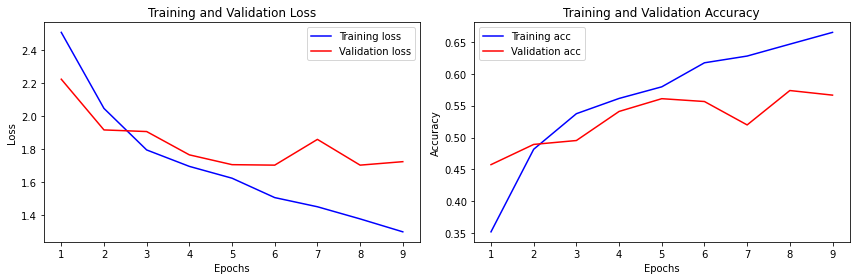

In [59]:
# history 객체로부터 손실 및 정확도 값 얻기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# 에폭 수
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
